# Personal Loan Acquisition

### Introduction

The task of this project is to develop a machine learning model to predict the likelihood of a customer purchasing a personal loan. This model will help the marketing team to identify potential customers who are more likely to convert, allowing more efficient and cost-effective campaigns.

The dataset contains: 
* Information on 5,000 clients from the bank.
* Primary key - Client Number
* 13 features related to client attributes such as, client age, income, credit card spending etc.
* Label - "LOAN_OFFER", whether or not the client accepted a personal loan offer.


This notebook will explore and prepare the provided dataset, apply various machine learning models, validate their performance, and present findings. The following steps are taken:
1. Setup
2. Import and View Data
3. Data Quality Check
4. Data Processing\
    4.1 Categorical Encoding\
    4.2 CLIENT_SINCE Conversion to Tenure\
    4.3 Clean Up CAREER_YR\
    4.4 Aggregate ZIP_CD to REGION\
    4.5 Clean Up
5. Feature Engineering\
    5.1 Univariate Analysis\
    5.2 Feature Correlation 
6. Model TDevelopment\
    6.1 Logistic Regression\
    6.2 XGBoost\
    6.3 Random Forest
7. Model Validation\
    7.1 Logistic Regression\
    7.2 XGBoost\
    7.3 Random Forest
8. Model Explaination and Conclusion


### 1. Setup

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
import shap

### 2. Import and View Data

Goal: Predict the likelihood of a customer purchasing a personal loan given the offer.

The data is presented with the following features:

| Feature | Description |
| --- | --- |
| CLIENT_NO | Client Number (Primary Key) |
| AGE | Client age in complete years |
| INCM | Annual income of the client ($000) |
| CAREER_YR | #years of professional career experience |
| CLIENT_SINCE |	date when client joined the bank |
| ZIP_CD	| Home ZIP Code |
| FAMILY	| Family size of the client |
| CC_SPENDING | Avg. spending on credit cards per month ($000) |
| EDUCATION | Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional |
| MTG_AMT | Value of house mortgage if any. ($000) |
| LOAN_OFFER | Label - Did this client accept the personal loan offered in the last campaign? |
| SAVING_ACCT |	Does the client have a savings account with the bank? |
| INV_ACCT | Does the client have a investment account with the bank? |
| OLB |	Does the client use online banking? |
| CC_OFI | Does the client use a credit card issued by other financial institutions? |





In [5]:
# Import and view data
source = pd.read_excel('Dataset.xlsx', 'Data')
df = source.copy()
df.head()

,CLIENT_NO,AGE,INCM,CAREER_YR,CLIENT_SINCE,ZIP_CD,FAMILY,CC_SPENDING,EDUCATION,MTG_AMT,LOAN_OFFER,SAVING_ACCT,INV_ACCT,OLB,CC_OFI
0,1,25,49,1,2018-10-12,91-107V,4,8.0,1,0,No,Yes,No,No,No
1,2,45,34,19,1999-05-17,90-089T,3,7.5,1,0,No,Yes,No,No,No
2,3,39,11,15,2016-01-08,94-720R,1,5.0,1,0,No,No,No,No,No
3,4,35,100,9,2013-07-31,94-112Y,1,13.5,2,0,No,No,No,No,No
4,5,35,45,8,2004-05-07,91-330B,4,5.0,2,0,No,No,No,No,Yes


In [6]:
# Obtain input data dimensions
print('Source data shape: ', df.shape)

Source data shape:  (5000, 15)


### 3. Data Quality Check

* No duplicates in primary key. 
* Renamed and encoded binary labels - positive rate of 9.6%.
* CLIENT_SINCE - datetime feature to be converted.
* CAREER_YR has negative values (-3, -2, -1). Distribution seems normal.
* MTG_AMT is highly right skewed.
* CC_SPENDING slightly right skewed.
* No NULL values.
* No Duplicates.
* SAVING_ACCT, INV_ACCT, OLB, CC_OFI - Yes/No features to be encoded to binary.
* ZIP_CD - to be aggregated if possible.



In [9]:
# Unique values in primary key
print('Total primary keys: ', df.shape[0])
print('Unique primary keys: ', df['CLIENT_NO'].nunique())

# Unique values in target label
print('Unique target labels: ', df['LOAN_OFFER'].unique())


Total primary keys:  5000
Unique primary keys:  5000
Unique target labels:  ['No' 'Yes']


In [10]:
# Encode and rename target label to binary: 1-Yes, 0-No
binary_map = {'Yes' : 1, 'No' : 0}
df['LABEL'] = df['LOAN_OFFER'].map(binary_map)

# Label percentage
print('Percentage of positive labels:', round(df['LABEL'].sum()*100/df.shape[0],2))

Percentage of positive labels: 9.6


In [12]:
# Check for numeric data distribution
df.describe()

,CLIENT_NO,AGE,INCM,CAREER_YR,CLIENT_SINCE,FAMILY,CC_SPENDING,EDUCATION,MTG_AMT,LABEL
count,5000.000000,5000.000000,5000.000000,5000.000000,5000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,45.338400,73.774200,20.104600,2010-10-14 09:10:22.080000,2.396400,9.689567,1.881000,56.498800,0.096000
min,1.000000,23.000000,8.000000,-3.000000,1998-01-03 00:00:00,1.000000,0.000000,1.000000,0.000000,0.000000
25%,1250.750000,35.000000,39.000000,10.000000,2004-04-28 18:00:00,1.000000,3.500000,1.000000,0.000000,0.000000
50%,2500.500000,45.000000,64.000000,20.000000,2010-08-27 00:00:00,2.000000,7.500000,2.000000,0.000000,0.000000
75%,3750.250000,55.000000,98.000000,30.000000,2017-04-01 06:00:00,3.000000,12.500000,3.000000,101.000000,0.000000
max,5000.000000,67.000000,224.000000,43.000000,2023-12-30 00:00:00,4.000000,50.000000,3.000000,635.000000,1.000000
std,1443.520003,11.463166,46.033729,11.467954,NaN,1.147663,8.738331,0.839869,101.713802,0.294621


<Axes: xlabel='CAREER_YR'>

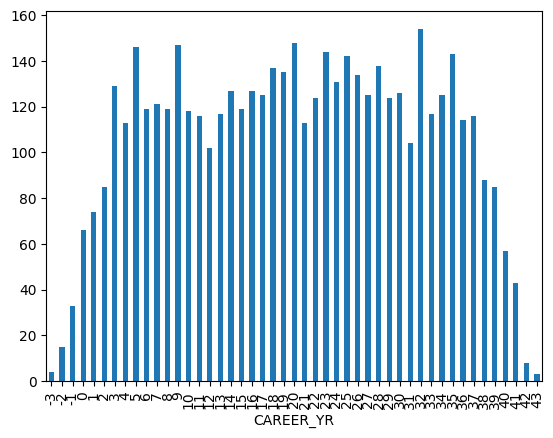

In [16]:
# CAREER_YR distribution
df['CAREER_YR'].value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='MTG_AMT'>

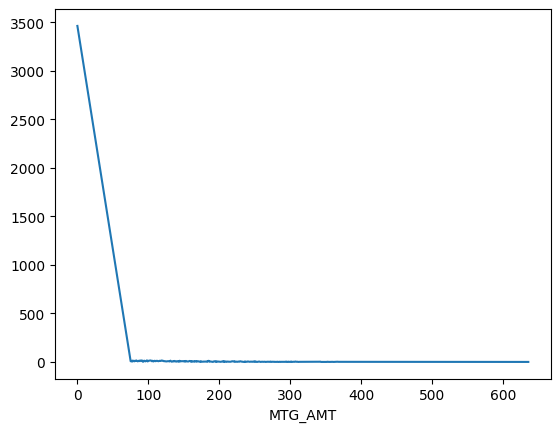

In [17]:
# MTG_AMT distribution
df['MTG_AMT'].value_counts().sort_index().plot(kind='line')

<Axes: xlabel='CC_SPENDING'>

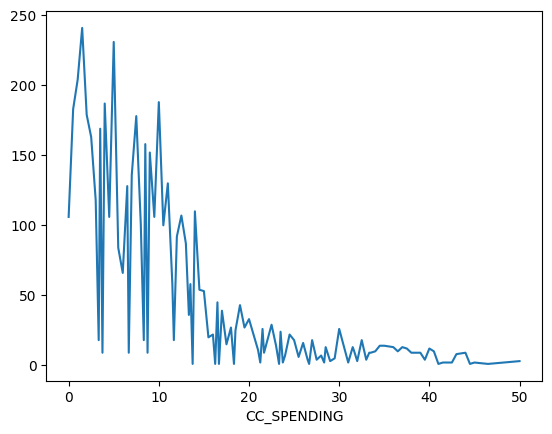

In [19]:
# CC_SPENDING distribution
df['CC_SPENDING'].value_counts().sort_index().plot(kind='line')

In [13]:
# Check for null values
df.isna().sum()

CLIENT_NO       0
AGE             0
INCM            0
CAREER_YR       0
CLIENT_SINCE    0
ZIP_CD          0
FAMILY          0
CC_SPENDING     0
EDUCATION       0
MTG_AMT         0
LOAN_OFFER      0
SAVING_ACCT     0
INV_ACCT        0
OLB             0
CC_OFI          0
LABEL           0
dtype: int64

In [14]:
# Check for duplicates
df.duplicated().sum()

0

In [15]:
# Check for column types
df.dtypes

CLIENT_NO                int64
AGE                      int64
INCM                     int64
CAREER_YR                int64
CLIENT_SINCE    datetime64[ns]
ZIP_CD                  object
FAMILY                   int64
CC_SPENDING            float64
EDUCATION                int64
MTG_AMT                  int64
LOAN_OFFER              object
SAVING_ACCT             object
INV_ACCT                object
OLB                     object
CC_OFI                  object
LABEL                    int64
dtype: object

### 4. Data Processing

#### 4.1 Categorical Encoding
Encoded binary categorical features SAVING_ACCT, INV_ACCT, OLB, CC_OFI to binary values.

In [20]:
# Encode categorical features to binary: 1-Yes, 0-No
df['SAVING_ACCT'] = df['SAVING_ACCT'].map(binary_map)
df['INV_ACCT'] = df['INV_ACCT'].map(binary_map)
df['OLB'] = df['OLB'].map(binary_map)
df['CC_OFI'] = df['CC_OFI'].map(binary_map)

In [21]:
df.head()

,CLIENT_NO,AGE,INCM,CAREER_YR,CLIENT_SINCE,ZIP_CD,FAMILY,CC_SPENDING,EDUCATION,MTG_AMT,LOAN_OFFER,SAVING_ACCT,INV_ACCT,OLB,CC_OFI,LABEL
0,1,25,49,1,2018-10-12,91-107V,4,8.0,1,0,No,1,0,0,0,0
1,2,45,34,19,1999-05-17,90-089T,3,7.5,1,0,No,1,0,0,0,0
2,3,39,11,15,2016-01-08,94-720R,1,5.0,1,0,No,0,0,0,0,0
3,4,35,100,9,2013-07-31,94-112Y,1,13.5,2,0,No,0,0,0,0,0
4,5,35,45,8,2004-05-07,91-330B,4,5.0,2,0,No,0,0,0,1,0


#### 4.2 CLIENT_SINCE Conversion to Tenure
Created TENURE feature based on CLIENT_SINCE feature using today's date. Rounded to the nearest year.

In [24]:
# Calculate client tenure in years
df['TODAY'] = pd.Timestamp('20240827')
df['TENURE'] = ((df['TODAY'] - df['CLIENT_SINCE'])/np.timedelta64(1,'D')/365).round(0).astype(int)
df.head()

,CLIENT_NO,AGE,INCM,CAREER_YR,CLIENT_SINCE,ZIP_CD,FAMILY,CC_SPENDING,EDUCATION,MTG_AMT,LOAN_OFFER,SAVING_ACCT,INV_ACCT,OLB,CC_OFI,LABEL,TODAY,TENURE
0,1,25,49,1,2018-10-12,91-107V,4,8.0,1,0,No,1,0,0,0,0,2024-08-27,6
1,2,45,34,19,1999-05-17,90-089T,3,7.5,1,0,No,1,0,0,0,0,2024-08-27,25
2,3,39,11,15,2016-01-08,94-720R,1,5.0,1,0,No,0,0,0,0,0,2024-08-27,9
3,4,35,100,9,2013-07-31,94-112Y,1,13.5,2,0,No,0,0,0,0,0,2024-08-27,11
4,5,35,45,8,2004-05-07,91-330B,4,5.0,2,0,No,0,0,0,1,0,2024-08-27,20


#### 4.3 Clean Up Negative Values in CAREER_YR
Clipped negative values to 0.

In [26]:
# Clipped negative values to 0
df['CAREER_YR'] = df['CAREER_YR'].clip(lower = 0)
df.head()

,CLIENT_NO,AGE,INCM,CAREER_YR,CLIENT_SINCE,ZIP_CD,FAMILY,CC_SPENDING,EDUCATION,MTG_AMT,LOAN_OFFER,SAVING_ACCT,INV_ACCT,OLB,CC_OFI,LABEL,TODAY,TENURE
0,1,25,49,1,2018-10-12,91-107V,4,8.0,1,0,No,1,0,0,0,0,2024-08-27,6
1,2,45,34,19,1999-05-17,90-089T,3,7.5,1,0,No,1,0,0,0,0,2024-08-27,25
2,3,39,11,15,2016-01-08,94-720R,1,5.0,1,0,No,0,0,0,0,0,2024-08-27,9
3,4,35,100,9,2013-07-31,94-112Y,1,13.5,2,0,No,0,0,0,0,0,2024-08-27,11
4,5,35,45,8,2004-05-07,91-330B,4,5.0,2,0,No,0,0,0,1,0,2024-08-27,20


In [27]:
df['CAREER_YR'].describe()

count    5000.000000
mean       20.119600
std        11.440484
min         0.000000
25%        10.000000
50%        20.000000
75%        30.000000
max        43.000000
Name: CAREER_YR, dtype: float64

#### 4.4 Aggregate ZIP_CD to Region
Due to no inherent meaning in ZIP_CD and the highly distinct values, ZIP_CD are aggregated to larger regions based on the first 2 letters (Assumption). 

In [28]:
# Number of distinct values in ZIP_CD
df['ZIP_CD'].nunique()

3486

In [29]:
# Use the first 2 letters of ZIP_CD to aggregate on REGION - assuming the first 2 letters are the representation of a larger region.
df['REGION'] = df['ZIP_CD'].str.slice(0,2)
df.head()

,CLIENT_NO,AGE,INCM,CAREER_YR,CLIENT_SINCE,ZIP_CD,FAMILY,CC_SPENDING,EDUCATION,MTG_AMT,LOAN_OFFER,SAVING_ACCT,INV_ACCT,OLB,CC_OFI,LABEL,TODAY,TENURE,REGION
0,1,25,49,1,2018-10-12,91-107V,4,8.0,1,0,No,1,0,0,0,0,2024-08-27,6,91
1,2,45,34,19,1999-05-17,90-089T,3,7.5,1,0,No,1,0,0,0,0,2024-08-27,25,90
2,3,39,11,15,2016-01-08,94-720R,1,5.0,1,0,No,0,0,0,0,0,2024-08-27,9,94
3,4,35,100,9,2013-07-31,94-112Y,1,13.5,2,0,No,0,0,0,0,0,2024-08-27,11,94
4,5,35,45,8,2004-05-07,91-330B,4,5.0,2,0,No,0,0,0,1,0,2024-08-27,20,91


In [31]:
# Number of distinct values in REGION
df['REGION'].nunique()

7

#### 4.5 Clean Up Features and Convert Data Types
* Non-predictive features are removed: CLIENT_NO
* Processed source features are removed: CLIENT_SINCE, TODAY, ZIP_CD, LOAN_OFFER
* Converted REGION to INT

In [35]:
df_cleaned = df.drop(columns = ['CLIENT_NO', 'CLIENT_SINCE', 'TODAY', 'ZIP_CD', 'LOAN_OFFER'])
df_cleaned['REGION'] = df_cleaned['REGION'].astype('int')
df_cleaned.head()

,AGE,INCM,CAREER_YR,FAMILY,CC_SPENDING,EDUCATION,MTG_AMT,SAVING_ACCT,INV_ACCT,OLB,CC_OFI,LABEL,TENURE,REGION
0,25,49,1,4,8.0,1,0,1,0,0,0,0,6,91
1,45,34,19,3,7.5,1,0,1,0,0,0,0,25,90
2,39,11,15,1,5.0,1,0,0,0,0,0,0,9,94
3,35,100,9,1,13.5,2,0,0,0,0,0,0,11,94
4,35,45,8,4,5.0,2,0,0,0,0,1,0,20,91


### 5. Feature Engineering
Due to the low number of features, no feature engineering was done. Univariate and correlation analysis are done to validate and select for non-correlated features. 
* Data split into 70/30 train/test before univariate analysis.
* Feature selection done using full data.

In [47]:
# Split the data into train and test sets
x = df_cleaned.drop('LABEL', axis=1)
y = df_cleaned['LABEL']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=12)

# Check positive rate in train and test data
print(y_train.sum()*100/x_train.shape[0])
print(y_test.sum()*100/x_test.shape[0])

df_train, df_test = train_test_split(df_cleaned, test_size=0.3, random_state=12)

9.685714285714285
9.4


#### 5.1 Univariate Analysis
* INCM, MTG_AMT, CC_SPENDING show strong correlation with LABEL - higher the amount, more likely to open personal loan. 
* AGE, TENURE, and CAREER_YR have fluctuating relationships with target label. 

In [87]:
# Create univariate analysis plot for each feature, with label positive rate for each bin

def univariate_plot (data, feature, num_bins):
    bins = np.linspace(data[feature].min(), data[feature].max(), num_bins + 1)
    labels = [f'{round(bins[i], 2)} - {round(bins[i+1], 2)}' for i in range(num_bins)]
    data['feature_bins'] = pd.cut(data[feature], bins=bins, labels=labels, include_lowest=True)

    hist_data = data['feature_bins'].value_counts().sort_index()
    label_percentage = data.groupby('feature_bins')['LABEL'].mean() * 100

    fig, ax1 = plt.subplots(figsize=(10, 6))

    hist_data.plot(kind='bar', alpha=0.5, color='blue', edgecolor='black', ax=ax1, width=0.8)
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Frequency')
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax2 = ax1.twinx()
    label_percentage.plot(kind='line', color='red', marker='o', ax=ax2)
    ax2.set_ylabel('Percentage of LABEL')

    plt.title('Histogram of {} with LABEL Percentage'.format(feature))
    plt.show()

    return 

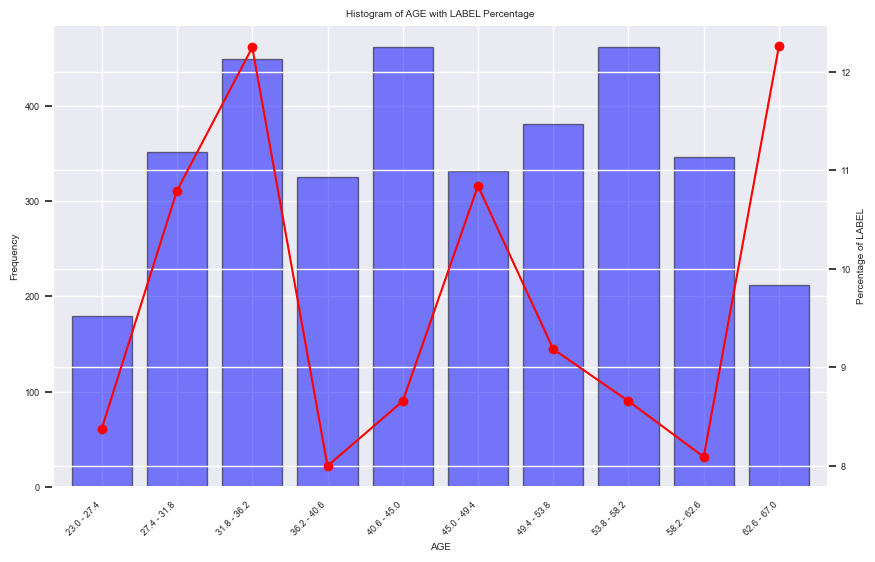

In [70]:
univariate_plot(df_train,'AGE',10)

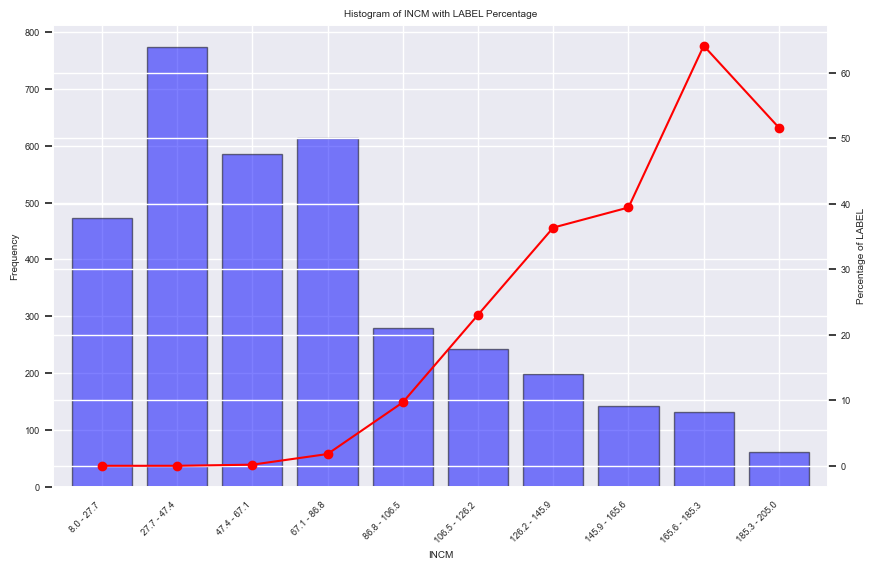

In [71]:
univariate_plot(df_train,'INCM',10)

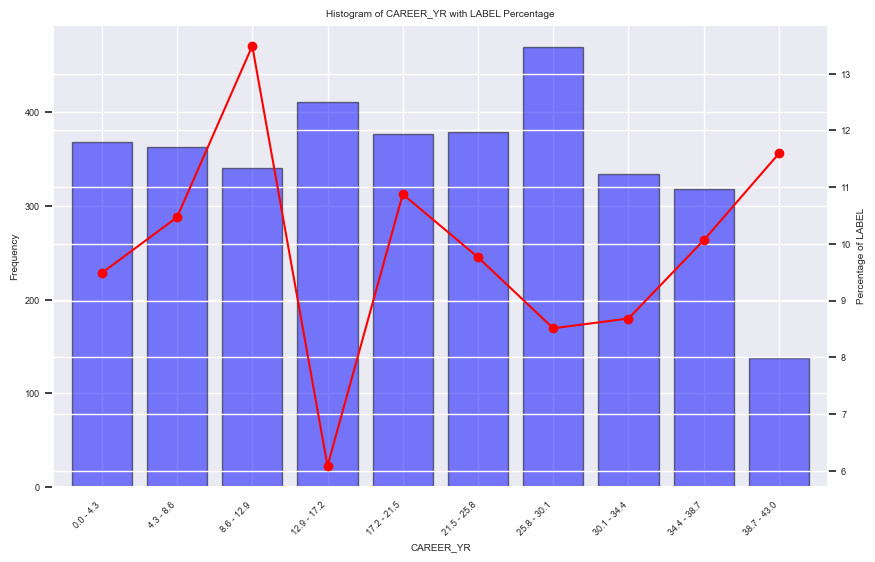

In [74]:
univariate_plot(df_train,'CAREER_YR',10)

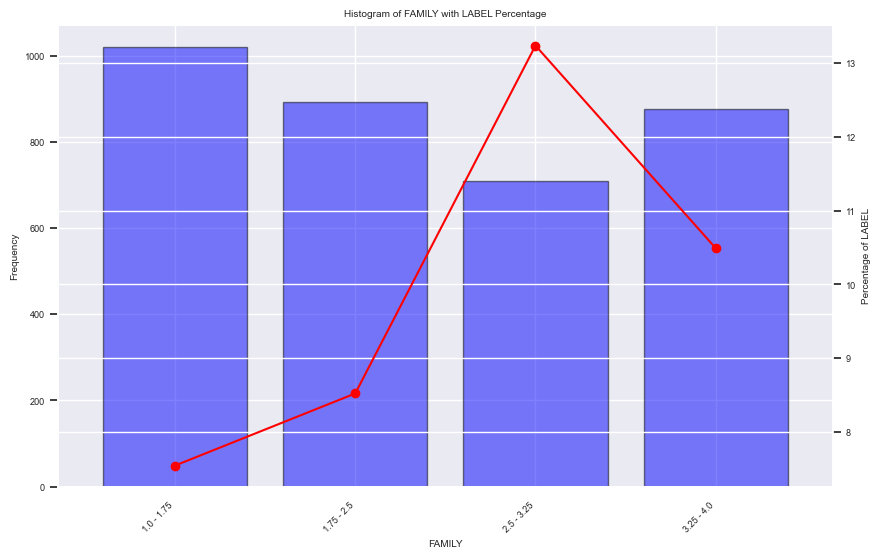

In [75]:
univariate_plot(df_train,'FAMILY',4)

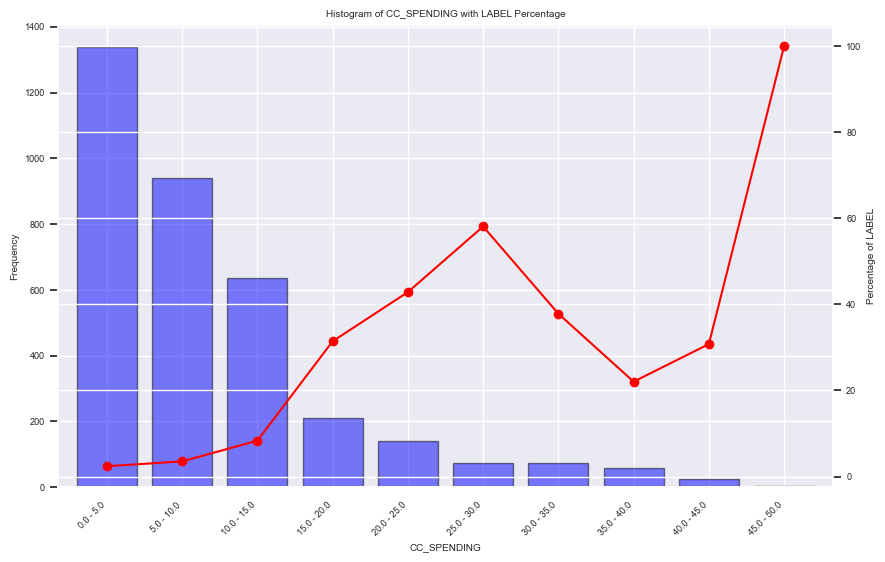

In [76]:
univariate_plot(df_train,'CC_SPENDING',10)

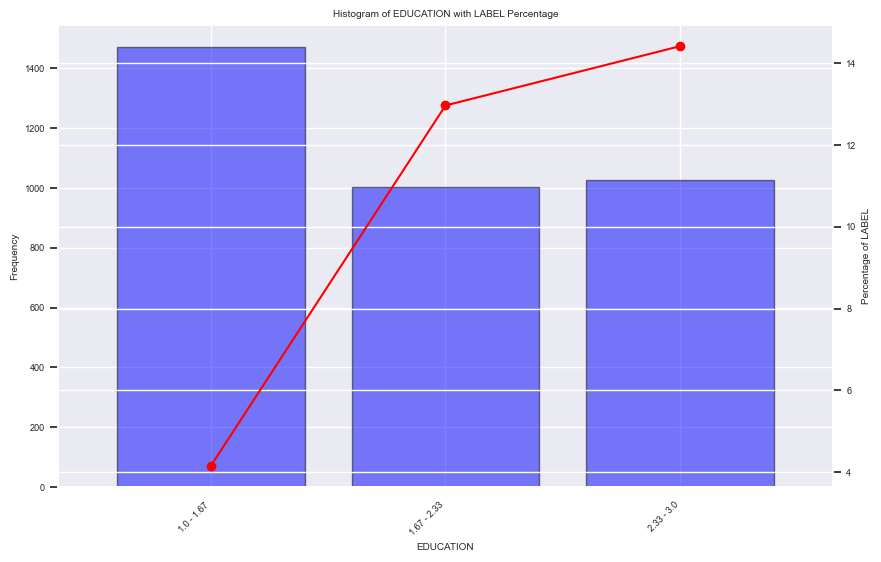

In [78]:
univariate_plot(df_train,'EDUCATION',3)

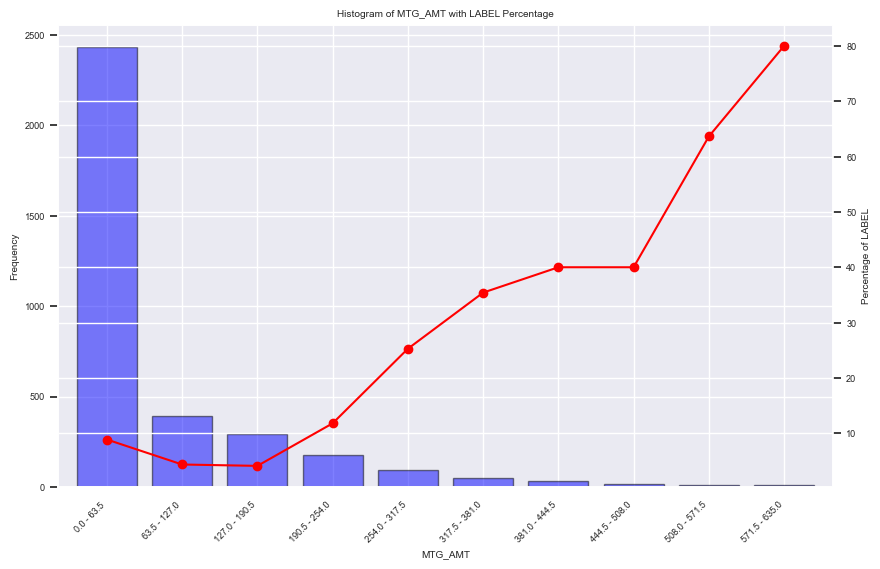

In [79]:
univariate_plot(df_train,'MTG_AMT',10)

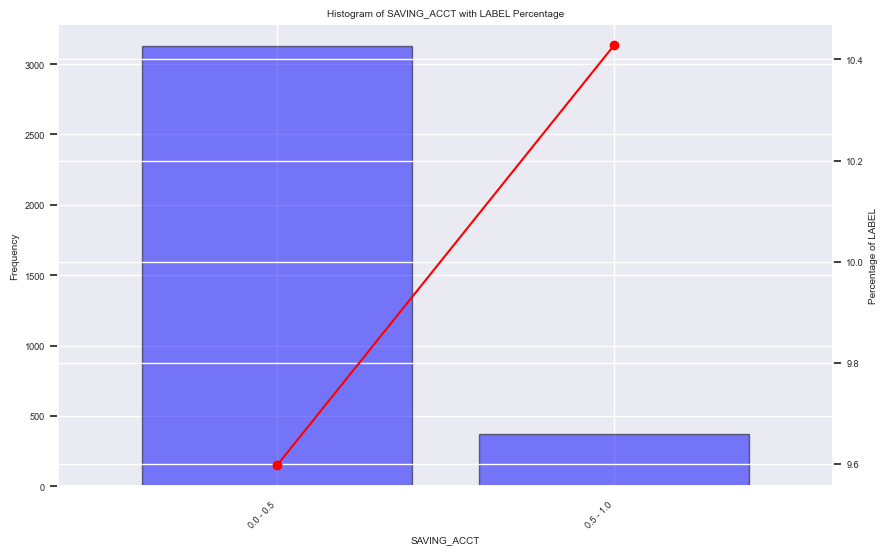

In [80]:
univariate_plot(df_train,'SAVING_ACCT',2)

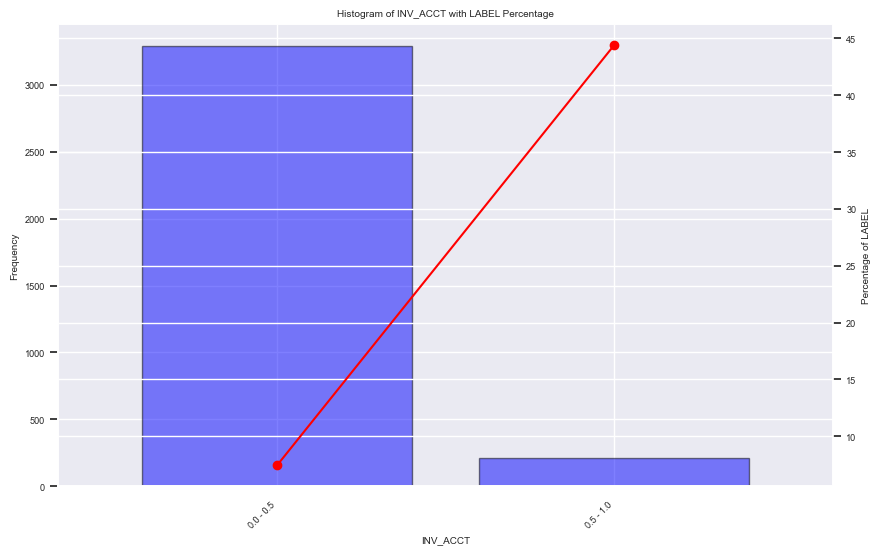

In [81]:
univariate_plot(df_train,'INV_ACCT',2)

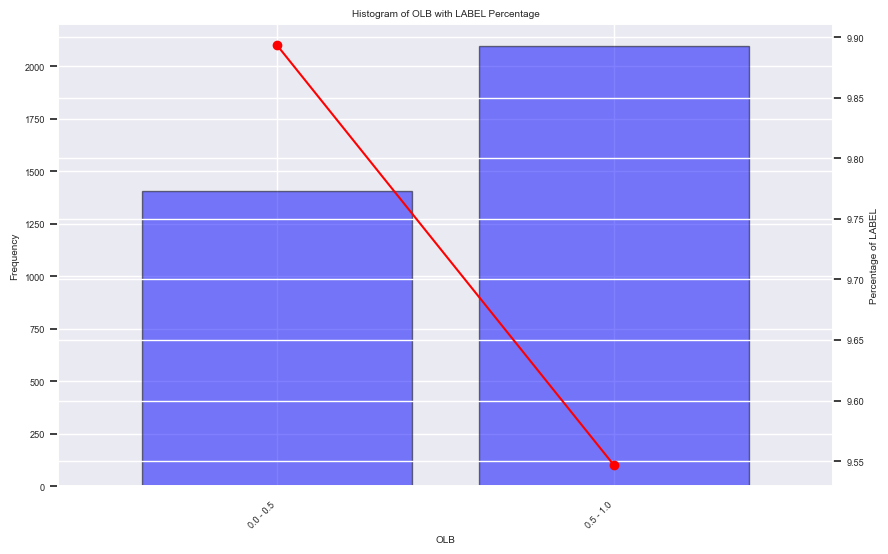

In [82]:
univariate_plot(df_train,'OLB',2)

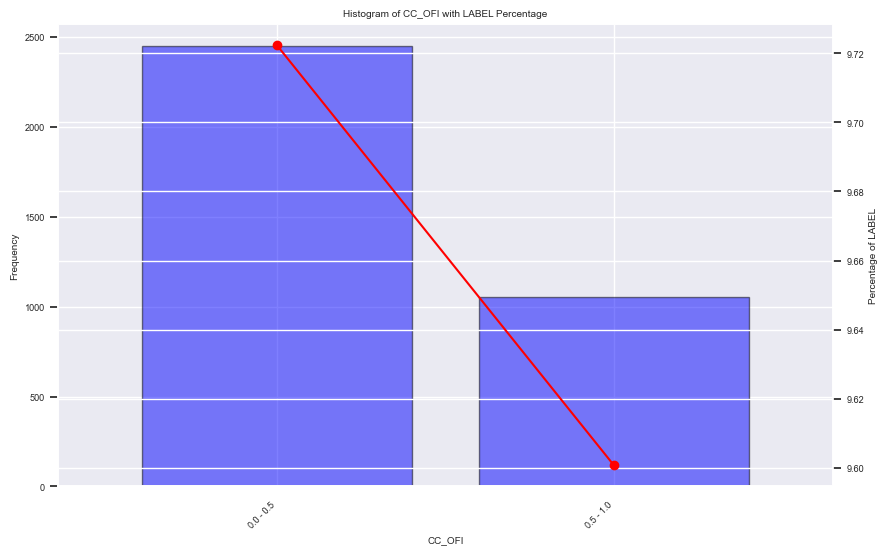

In [83]:
univariate_plot(df_train,'CC_OFI',2)

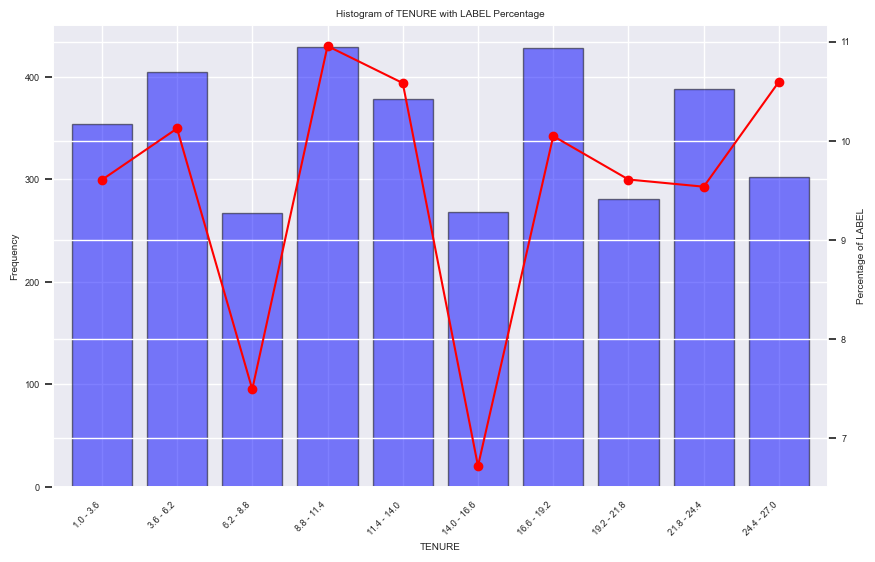

In [85]:
univariate_plot(df_train,'TENURE',10)

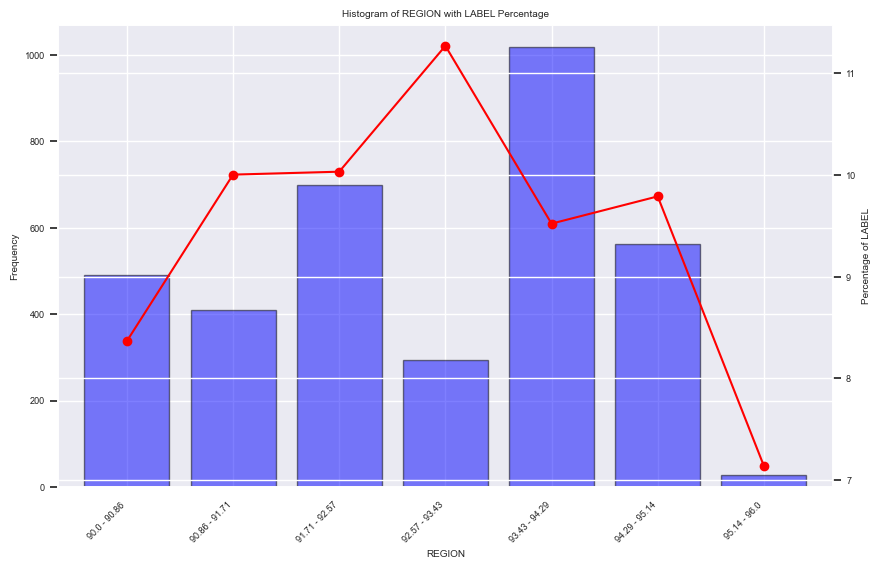

In [86]:
univariate_plot(df_train,'REGION',7)

#### 5.2 Feature Correlation
* CAREER_YR highly correlated with AGE (0.99) - CAREER_YR removed. 
* CC_SPENDING correlated  with INCM (0.65) - both kept since correlation is not too strong.

<Axes: >

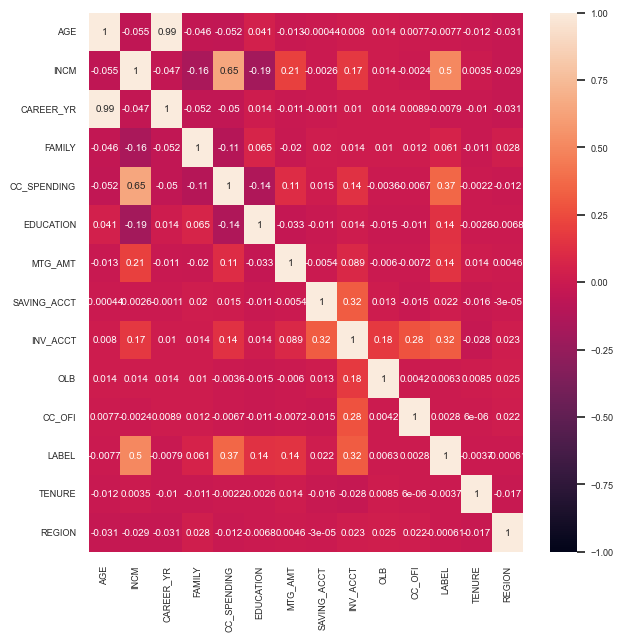

In [42]:
# Identify highly correlated features >0.95
sns.set(font_scale=0.6)
plt.figure(figsize=(7,7))
sns.heatmap(df_cleaned.corr(),vmax=1,vmin=-1,annot=True)

In [43]:
df_processed = df_cleaned.drop(columns = ['CAREER_YR'])

### 6. Model Development
Three model algorithms are explored and their associated validation AUC scores are below. All three models exhibit good performance in cross-validation.
| Model | AUC |
| --- | --- |
| Logistic Regression | 0.965 |
| XGBoost | 0.998 |
| Random Forest | 0.997 |


Grid search through hyperparameters are conducted with 5 folds of cross-validation.\
AUC score is used as the primary performance metric since it is a good balance between precision and recall for this marketing use case.
* Marketing to a client who is not going to take the offer will result in waste of marketing resources, however, depending on the nature of the marketing offer, clients who are not likely to take on the personal loan organically may respond well to marketing campaigns.
* The overall response rate of 9.6% is high for marketing campaigns. In market model validation will be done in the next section.
* Misclassifying clients who are organically going to take on a personal loan may reduce campaign effectiveness and performance, however, opportunity is not lost in this case since the client will organically open.

In [89]:
# Split the data into train and test sets
x = df_processed.drop('LABEL', axis=1)
y = df_processed['LABEL']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=12)

# Check positive rate in train and test data
print(y_train.sum()*100/x_train.shape[0])
print(y_test.sum()*100/x_test.shape[0])

9.685714285714285
9.4


#### 6.1 Logistic Regression
Due to the simplicity of data, logistic regression is used as the starting point of model development.

In [93]:
# Standardize train and test data
scaler = StandardScaler()
x_train_lr = scaler.fit_transform(x_train)
x_test_lr = scaler.fit_transform(x_test)

In [98]:
# Define model and parameters
model = LogisticRegression()

param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Penalty types 
    'solver': ['liblinear', 'saga'],  # Solver algorithms
    'max_iter': [100, 200]  # Maximum number of iterations
}

In [99]:
# Train model
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', verbose=1)
grid_search.fit(x_train_lr, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10], 'max_iter': [100, 200],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='roc_auc', verbose=1)

In [104]:
# Obtain best model, parameters, and scores
best_params_lr = grid_search.best_params_
best_model_lr = grid_search.best_estimator_
best_scores_lr = grid_search.best_score_

print(f"Best Parameters: {best_params_lr}")
print(f"Best AUC Score: {best_scores_lr}")

Best Parameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best AUC Score: 0.9651868327986322


#### 6.2 XGBoost

In [105]:
# Define model and parameters
model = xgb.XGBClassifier()

param_grid = {
        'max_depth': [3, 5, 10],
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'min_child_weight': [1],
        'alpha': [0.1],
        'gamma': [2],
        'scale_pos_weight': [90],
        'objective': ['binary:logistic'],
    }

In [106]:
# Train model
grid_search = GridSearchCV(model, param_grid, cv=5, scoring = 'roc_auc')
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'alpha': [0.1], 'gamma': [2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 10], 'min_child_weight': [1],
                         'n_estimators': [100, 200],
                         'objective': ['binary:logistic'],
                         'scale_pos_weight': [90]},
             scoring='roc_auc')

In [107]:
best_params_xgb = grid_search.best_params_
best_model_xgb = grid_search.best_estimator_
best_scores_xgb = grid_search.best_score_

print(f"Best Parameters: {best_params_xgb}")
print(f"Best Score: {best_scores_xgb}")

Best Parameters: {'alpha': 0.1, 'gamma': 2, 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'binary:logistic', 'scale_pos_weight': 90}
Best Score: 0.9980689704648548


#### 6.3 Random Forest

In [108]:
# Define model and parameter
model = RandomForestClassifier(class_weight='balanced', random_state=42)

param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [5, 10],
        'min_samples_split': [2, 5]
    }

In [109]:
# Train model
grid_search = GridSearchCV(model, param_grid, cv=5, scoring = 'roc_auc')
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [5, 10], 'min_samples_split': [2, 5],
                         'n_estimators': [50, 100]},
             scoring='roc_auc')

In [110]:
best_params_rf = grid_search.best_params_
best_model_rf = grid_search.best_estimator_
best_scores_rf = grid_search.best_score_

print(f"Best Parameters: {best_params_rf}")
print(f"Best Score: {best_scores_rf}")

Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}
Best Score: 0.9967063816509061


### 7. Model Validation
Model validation is done using the 30% validation population. The resulted AUC scores as well as lift over no-model performance at the top decile are summarized below.

| Model | AUC | Lift at Top Decile |
| --- | --- | --- |
| Logistic Regression | 0.94 | 6.95 |
| XGBoost | 0.99 | 8.79 |
| Random Forest | 0.99 | 8.94 |

In [166]:
# Model evaluation metrics
def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred_proba = model.predict_proba(x_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return {
        'AUC': auc,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }, y_pred_proba

# Compute response rate and lift performance
def compute_lift(scores):
    perf = scores.groupby('DECILE')['LABEL'].agg(['sum','count']).sort_values(by=['DECILE'], ascending = False)
    total_true_positive = scores['LABEL'].sum()
    organic_response = scores['LABEL'].sum()*100/scores.shape[0]

    perf['RESPONSE_RATE'] = perf['sum']*100/perf['count']
    perf['LIFT'] = perf['RESPONSE_RATE']/organic_response
    perf['CAPTURE_RATE'] = perf['sum']*100/total_true_positive
    perf['CUMMULATIVE_CAPTURE_RATE'] = perf['CAPTURE_RATE'].cumsum()

    return perf

#### 7.1 Logistic Regression

In [142]:
# Perform model validation and calculate scores
metrics, scores = evaluate_model(best_model_lr, x_test_lr, y_test)
    
result = {
        'Metric': ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Value': [metrics['AUC'], metrics['Accuracy'], metrics['Precision'], metrics['Recall'], metrics['F1 Score']]
    }
    
result_lr = pd.DataFrame(result)
result_lr

,Metric,Value
0,AUC,0.940048
1,Accuracy,0.946667
2,Precision,0.814433
3,Recall,0.560284
4,F1 Score,0.663866


In [167]:
# Rank clients into 10 deciles to calculate lift over no-model performance

scores_lr= pd.DataFrame(scores.reshape(-1),columns=['p1'])
scores_lr['DECILE'] = pd.qcut(scores_lr['p1'], 10, labels=np.arange(10,0,-1))
scores_lr = pd.concat([scores_lr.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

# Compute lift and response rates for each decile
perf_lr = compute_lift(scores_lr)

In [168]:
perf_lr

,sum,count,RESPONSE_RATE,LIFT,CAPTURE_RATE,CUMMULATIVE_CAPTURE_RATE
DECILE,,,,,,
1,98,150,65.333333,6.950355,69.503546,69.503546
2,24,150,16.000000,1.702128,17.021277,86.524823
3,8,150,5.333333,0.567376,5.673759,92.198582
4,6,150,4.000000,0.425532,4.255319,96.453901
5,2,150,1.333333,0.141844,1.418440,97.872340
6,0,150,0.000000,0.000000,0.000000,97.872340
7,1,150,0.666667,0.070922,0.709220,98.581560
8,2,150,1.333333,0.141844,1.418440,100.000000
9,0,150,0.000000,0.000000,0.000000,100.000000


#### 7.2 XGBoost

In [169]:
# Perform model validation and calculate scores
metrics, scores = evaluate_model(best_model_xgb, x_test, y_test)
    
result = {
        'Metric': ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Value': [metrics['AUC'], metrics['Accuracy'], metrics['Precision'], metrics['Recall'], metrics['F1 Score']]
    }
    
result_xgb = pd.DataFrame(result)
result_xgb

,Metric,Value
0,AUC,0.991859
1,Accuracy,0.969333
2,Precision,0.810458
3,Recall,0.879433
4,F1 Score,0.843537


In [192]:
# Rank clients into 10 deciles to calculate lift over no-model performance

scores_xgb= pd.DataFrame(scores.reshape(-1),columns=['p1'])
scores_xgb['DECILE'] = pd.qcut(scores_xgb['p1'].rank(method='first'), 10, labels=np.arange(10,0,-1))
scores_xgb = pd.concat([scores_xgb.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

# Compute lift and response rates for each decile
perf_xgb = compute_lift(scores_xgb)
perf_xgb

,sum,count,RESPONSE_RATE,LIFT,CAPTURE_RATE,CUMMULATIVE_CAPTURE_RATE
DECILE,,,,,,
1,124,150,82.666667,8.794326,87.943262,87.943262
2,15,150,10.000000,1.063830,10.638298,98.581560
3,1,150,0.666667,0.070922,0.709220,99.290780
4,1,150,0.666667,0.070922,0.709220,100.000000
5,0,150,0.000000,0.000000,0.000000,100.000000
6,0,150,0.000000,0.000000,0.000000,100.000000
7,0,150,0.000000,0.000000,0.000000,100.000000
8,0,150,0.000000,0.000000,0.000000,100.000000
9,0,150,0.000000,0.000000,0.000000,100.000000


#### 7.3 Random Forest

In [194]:
# Perform model validation and calculate scores
metrics, scores = evaluate_model(best_model_rf, x_test, y_test)
    
result = {
        'Metric': ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Value': [metrics['AUC'], metrics['Accuracy'], metrics['Precision'], metrics['Recall'], metrics['F1 Score']]
    }
    
result_rf = pd.DataFrame(result)
result_rf

,Metric,Value
0,AUC,0.990484
1,Accuracy,0.975333
2,Precision,0.882353
3,Recall,0.851064
4,F1 Score,0.866426


In [195]:
# Rank clients into 10 deciles to calculate lift over no-model performance

scores_rf= pd.DataFrame(scores.reshape(-1),columns=['p1'])
scores_rf['DECILE'] = pd.qcut(scores_rf['p1'].rank(method='first'), 10, labels=np.arange(10,0,-1))
scores_rf = pd.concat([scores_rf.reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)

# Compute lift and response rates for each decile
perf_rf = compute_lift(scores_rf)
perf_rf

,sum,count,RESPONSE_RATE,LIFT,CAPTURE_RATE,CUMMULATIVE_CAPTURE_RATE
DECILE,,,,,,
1,126,150,84.000000,8.936170,89.361702,89.361702
2,13,150,8.666667,0.921986,9.219858,98.581560
3,1,150,0.666667,0.070922,0.709220,99.290780
4,0,150,0.000000,0.000000,0.000000,99.290780
5,0,150,0.000000,0.000000,0.000000,99.290780
6,1,150,0.666667,0.070922,0.709220,100.000000
7,0,150,0.000000,0.000000,0.000000,100.000000
8,0,150,0.000000,0.000000,0.000000,100.000000
9,0,150,0.000000,0.000000,0.000000,100.000000


### 8. Model Selection and Conclusion
From a model validation standpoint, both XGBoost and Random Forest show a similar AUC score which out-performs Logistic Regression. When tested using lift metrics, Random Forest exhibits slightly higher lift at the top one decile compared to XGBoost - it is able to achieve 9X better results as compared to no-model. Looking at market-testing, it is suggested to productionize the Random Forest model as it has slightly higher lift.


The high lift/response rate and capture rate of the Random Forest at the top decile indicates that the majority of the responses (almost 90%) can be captured. The marketing campaign can effectively target the top decile (10% of the population), with the most response population, and therefore save cost.


Below are feature importance and their effect on model score explained using SHAP values. The features can be used to provide more business insights as to how the marketing campaign should be designed and about the targeted population.


| Rank | Feature | Explanation |
| --- | --- | --- |
| 1 | Annual Income | The higher the annual income, the more likely the client will take a personal loan offer |
| 2 | Education | The higher the education level, the more likely the client will take a personal loan offer |
| 3 | Average Amount Spent on Credit Card Per Month | The higher the credit card spend, the more likely the client will take a personal loan offer |
| 4 | Family Size | The larger the family, the more likely the client will take a personal loan offer |
| 5 | Investment Account | Having an investment account means that the client is more likely to take a personal loan offer |
| 6 | Value of House Mortgage | The higher the house mortgage, the more likely the client will take a personal loan offer |
| 7 | Client Age | Younger the client, the less likely the client will take a personal loan offer |
| 8 | Client Tenure | No clear binary distinction between labels |
| 9 | Online Banking | Using online banking lowers the likelihood of the client taking a personal loan offer |
| 10 | OFI Credit Card | Having an OFI credit card lowers the likelihood of the client taking a personal loan offer |
| 11 | Geographical Region | No clear explanation due to no inherent meaning in Region code |
| 12 | Saving Account | Having a saving account lowers the likelihood of the client taking a personal loan offer |


#### 8.1 Feature Explanation

In [235]:
shap.initjs()

In [249]:
# Calculate SHAP values for test set
explainer = shap.TreeExplainer(best_model_rf)
shap_values = explainer.shap_values(x_test, approximate=False, check_additivity=False)

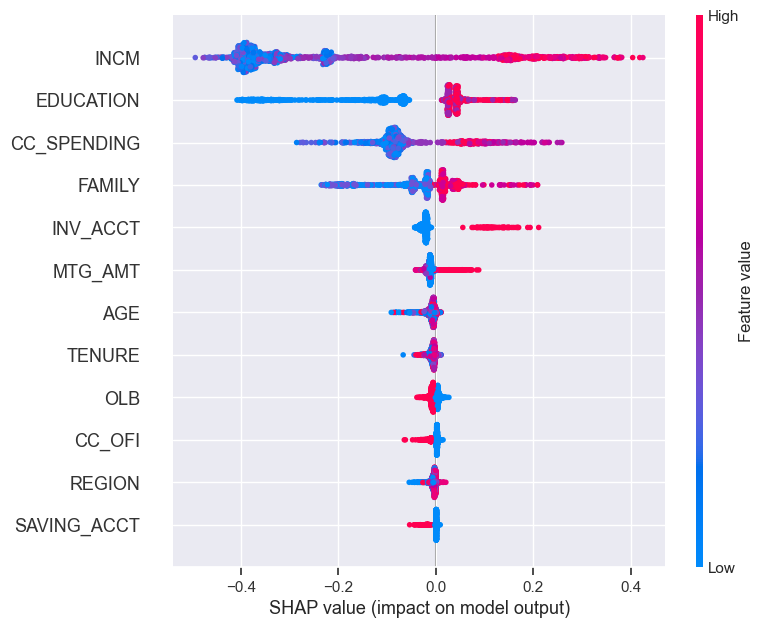

In [255]:
shap.summary_plot(shap_values[:,:,1], x_test)